Liên kết đến Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import thư viện, train và valid

In [ ]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16   # Áp dụng kiến trúc VGG16 của CNN

Xây dựng hàm huấn luyện mô hình CNN



Parameters:

    - train_dir: Đường dẫn đến thư mục Training (chứa các thư mục con như Apple 6, Apple 12, ...)
    - test_dir: Đường dẫn đến thư mục Test
    - num_nodes: Số nơ-ron trong lớp Dense
    - dropout_prob: Xác suất dropout để giảm overfitting
    - lr: Tỷ lệ học (learning rate)
    - batch_size: Kích thước batch
    - epochs: Số epoch huấn luyện

Returns:

    - nn_model: Mô hình đã huấn luyện
    - history: Lịch sử huấn luyện



In [ ]:
def train_cnn_model(train_dir, test_dir, num_nodes, dropout_prob, lr, batch_size, epochs, shuffle=True):

  #1. Tạo ImageDataGenerator để tải và tiền xử lý dữ liệu ảnh
  train_datagen = ImageDataGenerator(
      rescale=1./255,           # Chuẩn hóa giá trị pixel về [0, 1]
      rotation_range=10,        # Data augmentation: xoay ngẫu nhiên
      width_shift_range=0.1,    # Dịch ngang
      height_shift_range=0.1,   # Dịch dọc
      shear_range=0.1,          # Tạo ra một biến dạng trong đó các pixel bị kéo hoặc nghiêng theo một góc (được đo bằng độ hoặc tỷ lệ), tối đa 20%
      zoom_range=0.1,           # Phóng to
      horizontal_flip=True,     # Lật ngang ảnh ngẫu nhiên
      fill_mode='nearest'       # Xác định cách điền các pixel mới khi ảnh bị biến đổi (xoay, dịch, zoom, v.v.)
  )

  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(100, 100),   # Resize ảnh về 100x100
      batch_size=batch_size,
      class_mode='categorical',  # Phân loại đa lớp
      shuffle=shuffle
  )

  test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(100, 100),
      batch_size=batch_size,
      class_mode='categorical'
  )

  # 2. Xây dựng mô hình CNN
  cnn_model = tf.keras.Sequential([
      # Lớp Conv2D để trích xuất đặc trưng từ ảnh
      Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
      Dropout(0.3),
      Conv2D(64, (3, 3), activation='relu'),
      BatchNormalization(),
      MaxPooling2D((2, 2)),
      Dropout(0.3),
      Conv2D(128, (3, 3), activation='relu'),
      BatchNormalization(),
      MaxPooling2D((2, 2)),

      # Lớp Flatten để chuyển đổi đặc trưng thành vector 1 chiều
      Flatten(),

      # Lớp Dense để phân loại
      Dense(
          num_nodes,
          activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.01)),   # Phạt các trọng số lớn
      Dropout(dropout_prob),
      Dense(
          num_nodes,
          activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(0.01)),   # Phạt các trọng số lớn
      Dropout(dropout_prob),

      # Lớp đầu ra cho n lớp của dữ liệu được huấn luyện
      Dense(train_generator.num_classes, activation='softmax')
  ])

  # 3. Biên dịch mô hình
  cnn_model.compile(
      optimizer=tf.keras.optimizers.Adam(lr),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  # 4. Tính class weights (Xử lý trường hợp dữ liệu chênh lệch số lượng)
  class_labels = np.unique(train_generator.classes)
  class_weights = compute_class_weight(
        class_weight='balanced',
        classes=class_labels,
        y=train_generator.classes
  )
  class_weights_dict = dict(enumerate(class_weights))

  # 5. Thiết lập checkpoint để lưu mô hình
  checkpoint = ModelCheckpoint(
      '/content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_{epoch:02d}.h5',
      save_best_only=False,     # Lưu sau mỗi epoch
      save_weights_only=False,  # Lưu toàn bộ mô hình
      verbose=1
  )

  # 6. Thiết lập Early Stopping dừng training khi mô hình không cải thiện
  early_stopping = EarlyStopping(
      monitor='val_accuracy',
      patience=10,
      restore_best_weights=True
  )

  reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
  )

  # 7. Huấn luyện mô hình
  history = cnn_model.fit(
      train_generator,
      validation_data=test_generator,
      epochs=epochs,
      verbose=1,                # In thông tin huấn luyện
      callbacks=[checkpoint, early_stopping, reduce_lr],  # Checkpoints & early stopping
      class_weight=class_weights_dict
  )

  return cnn_model, history

### Tiến hành huấn luyện mô hình

Đường dẫn đến thư mục dữ liệu huấn luyện & test

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Test'

Huấn luyện mô hình

In [ ]:
model, history = train_cnn_model(
    train_dir=train_dir,
    test_dir=test_dir,
    num_nodes=128,
    dropout_prob=0.5,
    lr=0.0001,
    batch_size=32,
    epochs=50,
    shuffle=True
)

Found 2500 images belonging to 5 classes.
Found 902 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6107 - loss: 5.7842
Epoch 1: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_01.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 303s 3s/step - accuracy: 0.6124 - loss: 5.7715 - val_accuracy: 0.1851 - val_loss: 27.7849 - learning_rate: 0.0010
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8721 - loss: 3.3649
Epoch 2: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_02.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8725 - loss: 3.3603 - val_accuracy: 0.1851 - val_loss: 33.6103 - learning_rate: 0.0010
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9471 - loss: 2.2818
Epoch 3: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_03.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9469 - loss: 2.2803 - val_accuracy: 0.2627 - val_loss: 35.3789 - learning_rate: 0.0010
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9108 - loss: 1.9907
Epoch 4: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_04.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9110 - loss: 1.9893 - val_accuracy: 0.6585 - val_loss: 10.3642 - learning_rate: 0.0010
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9488 - loss: 1.4931
Epoch 5: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_05.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.9489 - loss: 1.4917 - val_accuracy: 0.6741 - val_loss: 5.7818 - learning_rate: 0.0010
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9520 - loss: 1.2637
Epoch 6: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_06.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9520 - loss: 1.2633 - val_accuracy: 0.9002 - val_loss: 1.6061 - learning_rate: 0.0010
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9575 - loss: 1.1259
Epoch 7: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_07.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9575 - loss: 1.1252 - val_accuracy: 0.8271 - val_loss: 1.9960 - learning_rate: 0.0010
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9648 - loss: 0.9379
Epoch 8: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_08.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9649 - loss: 0.9372 - val_accuracy: 0.8548 - val_loss: 1.2865 - learning_rate: 0.0010
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9825 - loss: 0.6941
Epoch 9: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_09.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9825 - loss: 0.6936 - val_accuracy: 0.8803 - val_loss: 0.9478 - learning_rate: 0.0010
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9746 - loss: 0.6427
Epoch 10: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_10.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9746 - loss: 0.6428 - val_accuracy: 0.9568 - val_loss: 0.6717 - learning_rate: 0.0010
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9619 - loss: 0.7146
Epoch 11: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_11.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.9620 - loss: 0.7147 - val_accuracy: 1.0000 - val_loss: 0.5929 - learning_rate: 0.0010
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9673 - loss: 0.7088
Epoch 12: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_12.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9673 - loss: 0.7093 - val_accuracy: 0.8370 - val_loss: 1.6181 - learning_rate: 0.0010
Epoch 13/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9589 - loss: 0.7635
Epoch 13: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_13.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9590 - loss: 0.7630 - val_accuracy: 1.0000 - val_loss: 0.5385 - learning_rate: 0.0010
Epoch 14/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9809 - loss: 0.5763
Epoch 14: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_14.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9809 - loss: 0.5760 - val_accuracy: 1.0000 - val_loss: 0.3983 - learning_rate: 0.0010
Epoch 15/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9777 - loss: 0.4371
Epoch 15: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_15.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9777 - loss: 0.4368 - val_accuracy: 1.0000 - val_loss: 0.3308 - learning_rate: 0.0010
Epoch 16/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9888 - loss: 0.3647
Epoch 16: saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_16.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9888 - loss: 0.3644 - val_accuracy: 1.0000 - val_loss: 0.2707 - learning_rate: 0.0010


### Kiểm tra kết quả

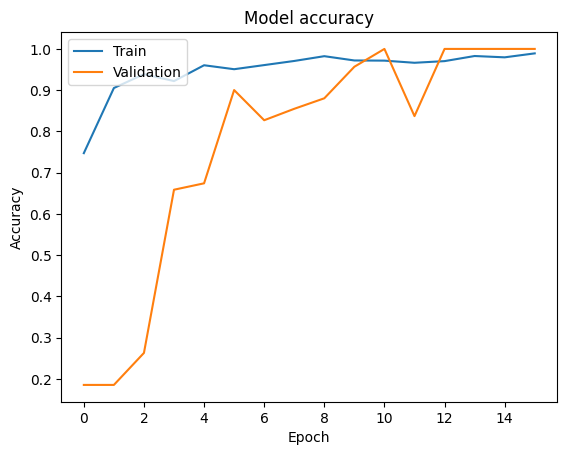

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Thử nghiệm mô hình

1. Tải mô hình

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Checkpoints/model_epoch_16.h5'
model = tf.keras.models.load_model(model_path)
print("Mô hình đã được tải thành công!")

Mô hình đã được tải thành công!


2. Tạo cấu trúc mô hình

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 98, 98, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 47, 47, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,749,831 (6.68 MB)

 Trainable params: 1,749,381 (6.67 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

3. Lấy số lớp (classnames) đầu ra

In [1]:
output_layer = model.layers[-1]
num_classes = output_layer.units
print(f"Số lượng lớp (classes) của mô hình: {num_classes}")

NameError: name 'model' is not defined

4. Xác nhận bằng dự đoán

In [ ]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Test/Apple_Rot/r0_131_100.jpg')
image = cv.resize(image, (100, 100)) / 255.0
image = np.expand_dims(image, axis=0)
predictions = model.predict(image)
num_classes_from_prediction = predictions.shape[1]
print(f"Số lượng lớp (classes) dựa trên dự đoán: {num_classes_from_prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Số lượng lớp (classes) dựa trên dự đoán: 5


5. Lấy thứ tự nhãn

In [ ]:
# In thứ tự nhãn
print("Thứ tự nhãn (class indices):")
print(test_generator.class_indices)

# Lấy danh sách tên lớp theo thứ tự huấn luyện
true_class_names = list(test_generator.class_indices.keys())
print("Danh sách lớp theo thứ tự huấn luyện:", true_class_names)

Thứ tự nhãn (class indices):
{'Apple_Live': 0, 'Apple_Ripe': 1, 'Apple_Rot': 2, 'Banana_Ripe': 3, 'Orange_Ripe': 4}
Danh sách lớp theo thứ tự huấn luyện: ['Apple_Live', 'Apple_Ripe', 'Apple_Rot', 'Banana_Ripe', 'Orange_Ripe']


5. Thử nghiệm mô hình

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Xác suất dự đoán cho từng lớp:
Lớp 1: Apple_Live: 100.00%
Lớp 2: Apple_Ripe: 0.00%
Lớp 3: Apple_Rot: 0.00%
Lớp 4: Banana_Ripe: 0.00%
Lớp 5: Orange_Ripe: 0.00%

Top 5 lớp có xác suất cao nhất:
Xếp hạng 1: Apple_Live - 100.00%
Xếp hạng 2: Apple_Ripe - 0.00%
Xếp hạng 3: Orange_Ripe - 0.00%
Xếp hạng 4: Banana_Ripe - 0.00%
Xếp hạng 5: Apple_Rot - 0.00%


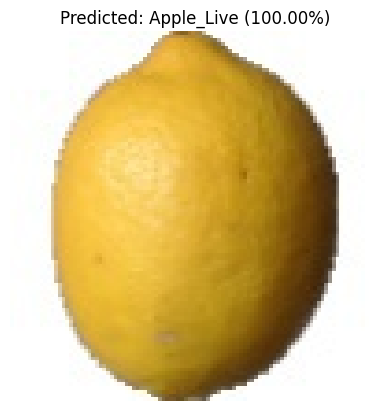

In [ ]:
# Danh sách tên lớp
class_names = true_class_names

# Đọc và tiền xử lý ảnh
image_path = '/content/drive/MyDrive/Colab Notebooks/Fruits360/Lite 15.03.2025/Test/Lemon 1/44_100.jpg'
image = cv.imread(image_path)
image = cv.resize(image, (100, 100)) / 255.0
image = np.expand_dims(image, axis=0)

# Dự đoán
predictions = model.predict(image)

# In tất cả xác suất
print("Xác suất dự đoán cho từng lớp:")
for i, (prob, class_name) in enumerate(zip(predictions[0], class_names)):
    print(f"Lớp {i+1}: {class_name}: {prob * 100:.2f}%")

# Lấy top 5 lớp có xác suất cao nhất
top_5_indices = np.argsort(predictions[0])[::-1][:5]
print("\nTop 5 lớp có xác suất cao nhất:")
for i, idx in enumerate(top_5_indices, 1):
    print(f"Xếp hạng {i}: {class_names[idx]} - {predictions[0][idx] * 100:.2f}%")

# Hiển thị ảnh với lớp dự đoán chính
predicted_class = np.argmax(predictions[0])
confidence = predictions[0][predicted_class] * 100

plt.imshow(cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB))
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.2f}%)")
plt.axis('off')
plt.show()





---



Kiểm tra số lượng ảnh

In [ ]:
import os
train_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Training'
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    print(f"{folder}: {len(os.listdir(folder_path))} images")

Apple_Rot: 500 images
Banana_Ripe: 500 images
Apple_Live: 500 images
Orange_Ripe: 500 images
Apple_Ripe: 500 images


Giảm số lượng ảnh của 1 thư mục

In [ ]:
import os
import random
import shutil

train_dir = '/content/drive/MyDrive/Colab Notebooks/CustomDatasetFruits/Training'
class_name = 'Apple_Rot'
folder_path = os.path.join(train_dir, class_name)

# Lấy danh sách ảnh
images = os.listdir(folder_path)
num_images = len(images)
target_num = 500  # Số ảnh mong muốn

if num_images > target_num:
    # Chọn ngẫu nhiên các ảnh để xóa
    images_to_remove = random.sample(images, num_images - target_num)
    for image in images_to_remove:
        os.remove(os.path.join(folder_path, image))
    print(f"Đã giảm số lượng ảnh của {class_name} xuống {target_num}")

Đã giảm số lượng ảnh của Apple_Rot xuống 500


Tăng số lượng ảnh của 1 Class từ Data Augmentation

In [ ]:
# Tạo datagen để augment ảnh
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Đọc ảnh từ lớp [tên thư mục]
folder_path = os.path.join(train_dir, 'Orange_Ripe')
images = os.listdir(folder_path)
target_num = 500  # Số ảnh mong muốn

for image_name in images:
    if len(os.listdir(folder_path)) >= target_num:
        break
    image = cv.imread(os.path.join(folder_path, image_name))
    image = cv.resize(image, (100, 100)) / 255.0
    image = np.expand_dims(image, axis=0)

    # Tạo ảnh mới
    i = 0
    for batch in datagen.flow(image, batch_size=1, save_to_dir=folder_path, save_prefix='aug', save_format='jpg'):
        i += 1
        if i > 1:  # Tạo 1 ảnh mới cho mỗi ảnh gốc
            break
print(f"Đã tăng số lượng ảnh của Apple_Rot lên {len(os.listdir(folder_path))}")

Đã tăng số lượng ảnh của Apple_Rot lên 500
